In [7]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path
from gensim.models import Word2Vec
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [8]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")

medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

In [9]:
def embeddings(graph: nx.Graph):
    # Create adjacency matrix with 32-bit float precision
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes), dtype=np.float32)
    
    # Degree matrix (diagonal matrix with node degrees)
    degree_matrix = np.diag(adjacency_matrix.sum(axis=1)) 
    
    # Laplacian matrix: Degree matrix - Adjacency matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    # Eigen decomposition: Using eigh for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    return eigenvalues, eigenvectors

Compute the full eigenvector and make elbow curve to find ideal amount of vectors

TypeError: plot() got an unexpected keyword argument 'x'

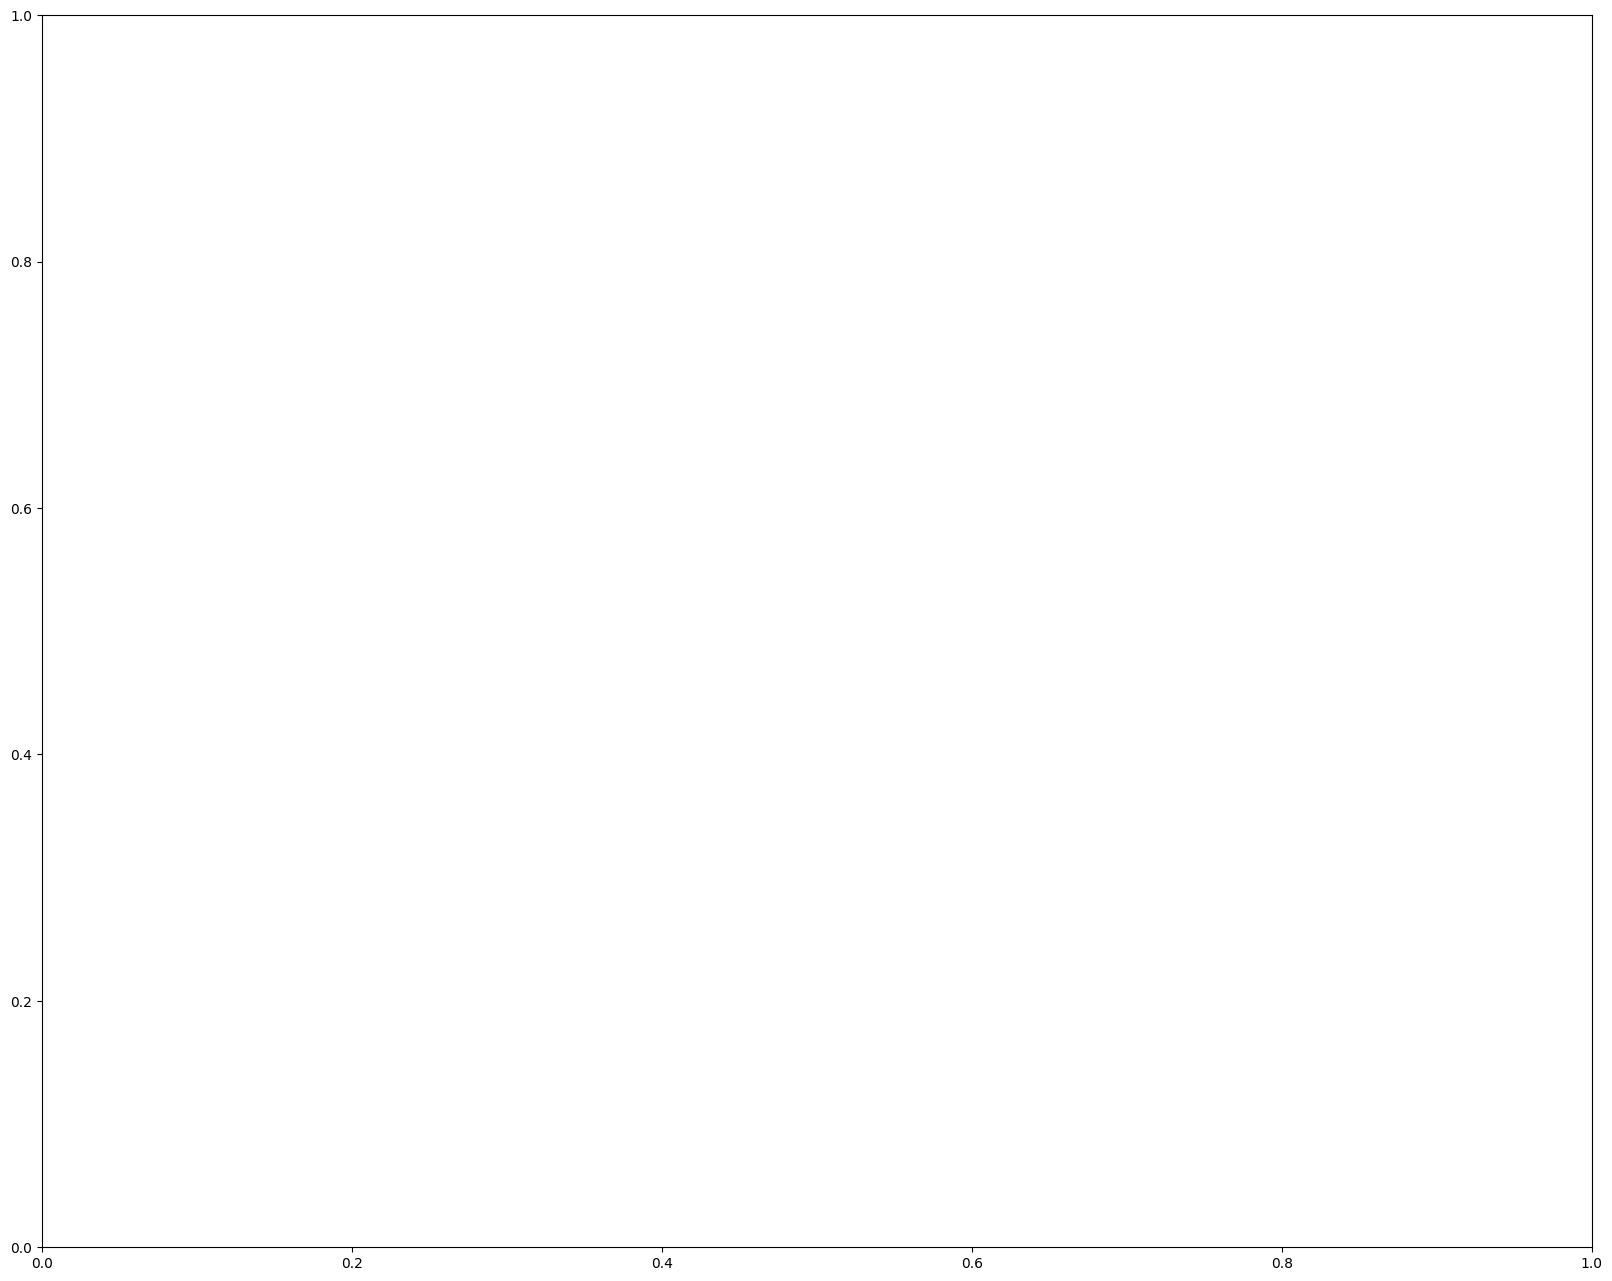

In [10]:
eigenvalues, eigenvectors = embeddings(medium_graph) 

eigenSum = [0]
for i in range(len(eigenvalues)):
    eigenSum.append(eigenSum[-1] + eigenvalues[i])
    

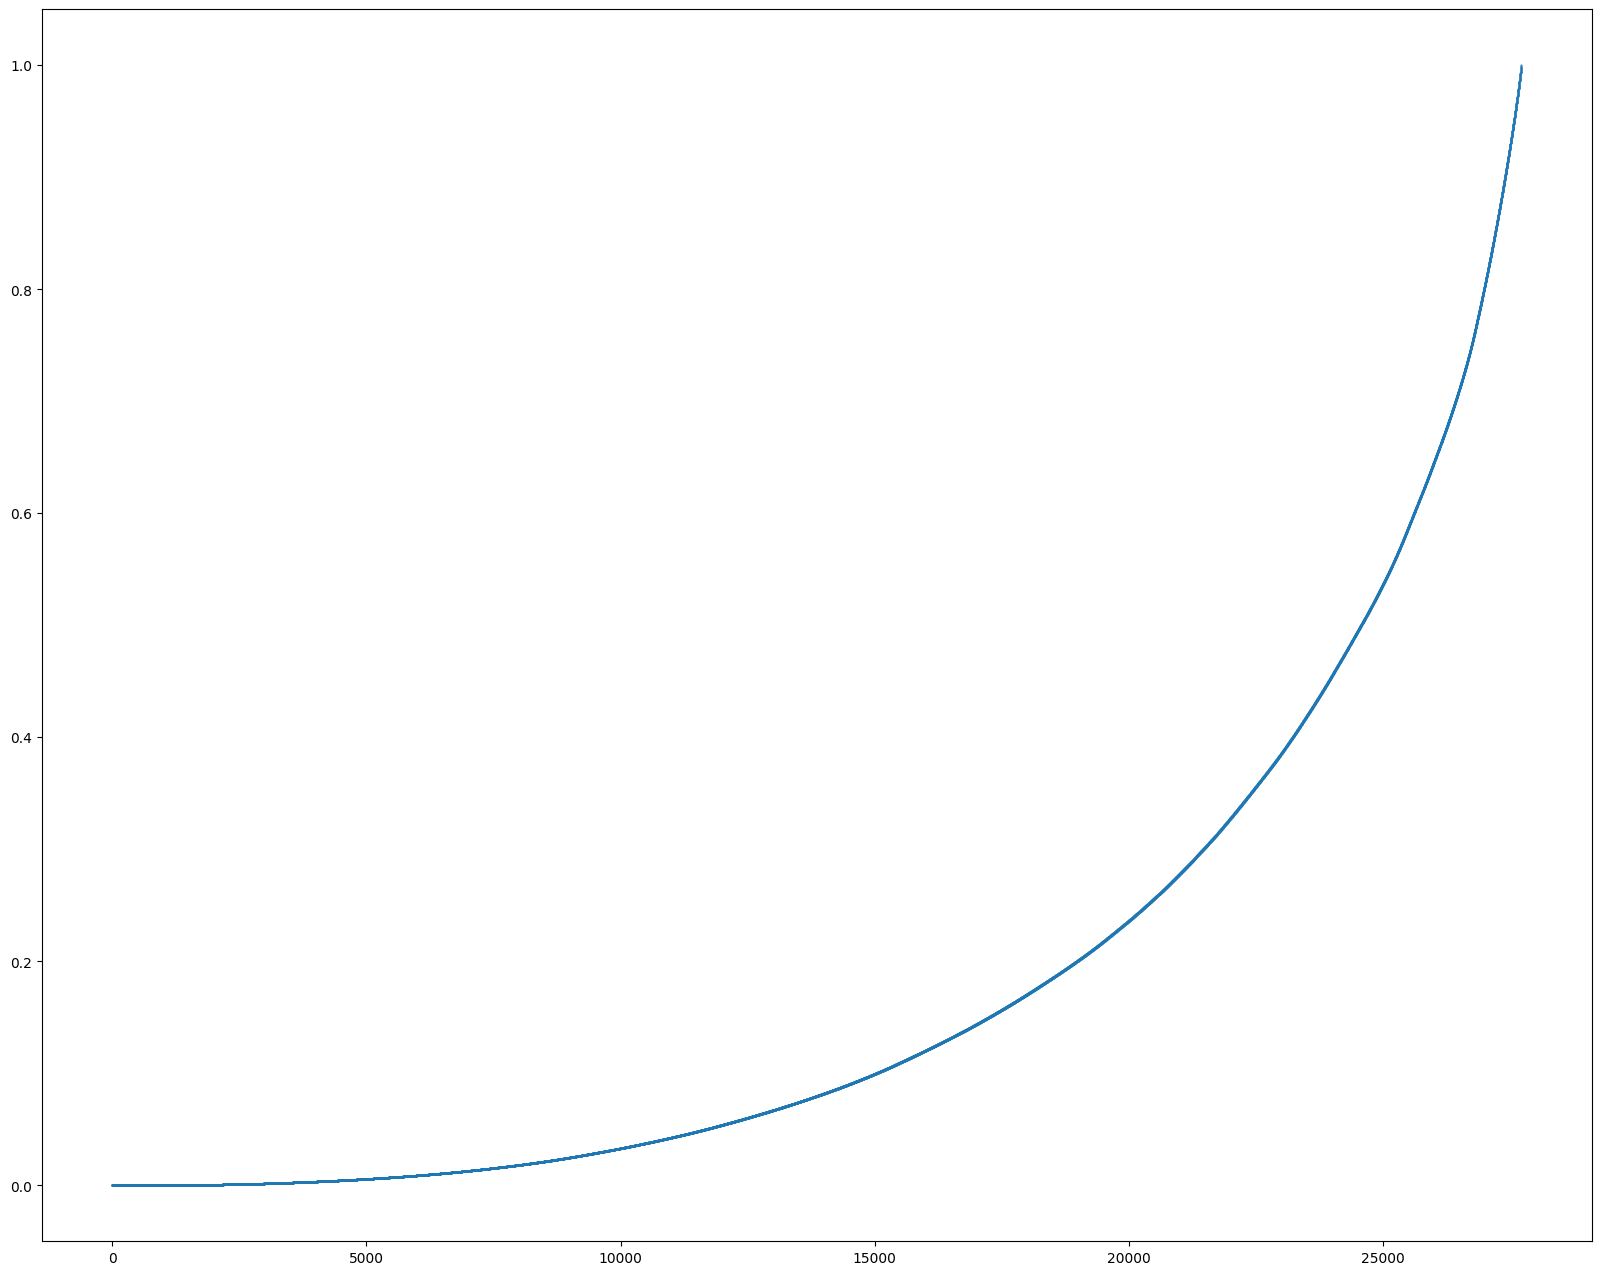

In [15]:
eigsum = eigenSum[-1]
pyplot.figure(figsize=(20,16))
pyplot.scatter([i for i in range(len(eigenSum))],np.array(eigenSum)/eigsum, s = 0.2)
pyplot.show()

In [17]:

def compute_distances(matrix, location):
    squared_matrix = np.sum(matrix**2, axis=1).reshape(-1, 1)
    squared_distances = squared_matrix + squared_matrix.T - 2 * np.dot(matrix, matrix.T)
    np.fill_diagonal(squared_distances, np.inf)
    distances = np.sqrt(squared_distances)
    
    print("Saving eigenvectors to CSV...")
    pd.DataFrame(distances).to_csv(location, index=False, header=False)
    return distances

In [ ]:
output_csv_path = "distance_matrix.csv"
distance = compute_distances(eigenvectors[:,:12000], output_csv_path) 

C:\Users\satya\AppData\Local\Temp\ipykernel_20256\2372487341.py:5: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(squared_distances)


Saving eigenvectors to CSV...


array([[       inf, 0.13700674, 1.0042009 , ..., 0.693977  , 1.0015327 ,
        1.0042416 ],
       [0.13700674,        inf, 1.0050805 , ..., 0.6952558 , 1.002415  ,
        1.00512   ],
       [1.0042009 , 1.0050805 ,        inf, ..., 1.2136745 , 1.4122636 ,
        1.4141848 ],
       ...,
       [0.693977  , 0.6952558 , 1.2136745 , ...,        inf, 1.2114745 ,
        1.2137135 ],
       [1.0015327 , 1.002415  , 1.4122636 , ..., 1.2114745 ,        inf,
        1.4122925 ],
       [1.0042416 , 1.00512   , 1.4141848 , ..., 1.2137135 , 1.4122925 ,
               inf]], dtype=float32)

In [36]:
distance = pd.read_csv("distance_matrix.csv" )

def create_node_label_dict(csv_file_path):
    df = pd.read_csv(csv_file_path)
    
    node_label_dict = pd.Series(df['label'].values, index=df['node_id']).to_dict()
    
    return node_label_dict
csv_file_path = Path("data") / "train_data.csv" 
dict_labels = create_node_label_dict(csv_file_path)

print(dict.get(-1))


None


In [49]:

k = 50
# def knn(matrix, k):
#     classification = []
#     for i in range(len(matrix)):
#         print(f"Completed for: {i}")
#         nearest_neighbors = np.argsort(matrix[i])[:k]
#         occurance = []
#         for i in nearest_neighbors:
#             occurance.append(dict.get(i))
    
    
#     return classification

def knn_calc(matrix, k, dict_labels):
    classification = []
    
    for i in range(len(matrix)):
        
        nearest_neighbors = np.argsort(matrix[i])[:k]
        label_counts = [0, 0, 0, 0]  # Software Development, AI, UX, Other
        

        for neighbor_index in nearest_neighbors:
            label = dict_labels.get(neighbor_index, 'unknown')
            
            if label == "artificial-intelligence":
                label_counts[1] += 1
            elif label == "software-development":
                label_counts[0] += 1
            elif label == "ux":
                label_counts[2] += 1
            else:
                label_counts[3] += 1
        
        npLabels = np.array(label_counts)
        
        max_index = npLabels.argmax()
        
        if max_index == 0:
            ofClass = "software-development"
        elif max_index == 1:
            ofClass = "artificial-intelligence"
        elif max_index == 2:
            ofClass = "ux"
        else:
            ofClass = "other"
        print(f"{ofClass}")
        classification.append(ofClass)

    return classification

distance = np.array(distance)

In [50]:
result = knn_calc(distance, 50, dict_labels)

artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
software-development
artificial-intelligence
artificial-intelligence
artificial-intelligence
software-development
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
artificial-intelligence
software-development
software-development
artificial-intelligence
arti

In [51]:
import csv

indices = result

data = [(i, value) for i, value in enumerate(indices)]

with open('index_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Index', 'Label'])
    for row in data:
        writer.writerow(row)

print("CSV file 'index_labels.csv' has been created.")

CSV file 'index_labels.csv' has been created.


In [ ]:
## Get accuracy

csv_file_path_test = Path("data") / "test_data.csv" 
dict_labels_test = create_node_label_dict(csv_file_path_test)
c = 0
t = 0
for i in range(len(result)):
    prediction = result[i]
    test = dict_labels_test.get(i)
    tOf = test == prediction
    if(test == None):
        continue
    print(f"For Index : {i} | Prediction: {prediction} | Value: {test} | Are Equal : {tOf}")
    if(test == prediction):
        c = c+1
    t = t+1
accuracy = c / t

print(accuracy)



For Index : 0 | Prediction: artificial-intelligence | Value: None
For Index : 1 | Prediction: artificial-intelligence | Value: None
For Index : 2 | Prediction: artificial-intelligence | Value: None
For Index : 3 | Prediction: artificial-intelligence | Value: None
For Index : 4 | Prediction: artificial-intelligence | Value: artificial-intelligence
For Index : 5 | Prediction: artificial-intelligence | Value: None
For Index : 6 | Prediction: artificial-intelligence | Value: None
For Index : 7 | Prediction: artificial-intelligence | Value: None
For Index : 8 | Prediction: artificial-intelligence | Value: None
For Index : 9 | Prediction: artificial-intelligence | Value: None
For Index : 10 | Prediction: artificial-intelligence | Value: None
For Index : 11 | Prediction: artificial-intelligence | Value: None
For Index : 12 | Prediction: artificial-intelligence | Value: None
For Index : 13 | Prediction: artificial-intelligence | Value: None
For Index : 14 | Prediction: artificial-intelligence 